# Homework 2: Field of Streams
## Margaret Lazzarini
## ASTR 597: Big Data

### Task 1
Write a query (either SQL or for LSD) to select stars satisfying the g−r<0.4 color selection criterion (see Section 2 of Belokurov et al. 2006). You're free to either run this query against the CasJobs SDSS database, or the LSD copy of the database.

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import pandas as pd
import sqlite3

In [15]:
from lsd import DB
from lsd.bounds import beam, rectangle

In [16]:
#Setting LSD parameters
import os
os.environ['NWORKERS'] = '8'
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_TEMPDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb'

In [17]:
#Check that the table is being accessed, which columns are contained.
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb/sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                gE

In [18]:
#Double check environmental parameters
print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/apps6/opt/lsddb
/astro/users/mlazz/tempdir
/astro/users/mlazz/tempdir


In [19]:
db = DB(os.environ['LSD_DB'])

In [20]:
from lsd.join_ops import Query

### Figure Description from Belokurov+ 2006, Figure 1
Spatial density of SDSS stars with around the north Galactic cap in equatorial coordinates, binned . The color plot is an RGB g  r ! 0.4 0.5 # 0.5
composite with blue for the most nearby stars with , green for stars with , and red for the most distant stars with 20.0 ! r ≤ 20.66 20.66 ! r ≤ 21.33 21.33 ! r ≤
22.0. Note the bifurcation in the stream starting at . Further structure that is visible includes the Monoceros Ring at and a new thin stream at a ≈ 180 a ≈ 120
150  a  160 and . The color bar shows a palette of 50 representative colors labeled according to the stellar density (in units of 100 stars per 0  d  30
square degree) in each of the red, green, and blue components. The displayed density ranges are 102–330 (red), 107–304 (green), and 98–267 (blue).
Fig. 2

In [97]:
#Query LSD SDSS database using SQL language and fetch matching rows
rows = db.query('SELECT sdss_id, ra, dec, g, r FROM sdss WHERE (g-r<0.4) & (type==6)').fetch()

 [1606 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::::::::::::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::::>  43.04 sec


In [98]:
#Convert LSD output to Pandas table
field = Table(rows.as_ndarray())

In [99]:
field[:5]

sdss_id,ra,dec,g,r
uint64,float64,float64,float32,float32
8349955184121610691,157.042246345,78.1808518805,20.6442,20.3202
8349955184121610693,157.29264222,78.2135602137,18.2156,17.9016
8349955184121610694,157.513423889,78.2139398528,16.9332,16.6143
8349955184121610710,157.269062023,78.2201755627,19.4232,19.1347
8349955184121610736,157.00167897,78.1878009878,27.8226,30.0


In [100]:
#Set histogram bin edges, each bin should step by 0.5˚ x 0.5˚
ra_edges = np.arange(110,230,0.5)
dec_edges = np.arange(-5,60,0.5)

In [101]:
#Set up masks to define the different colors
mask_red = (field['r']>21.33) & (field['r']<=22.0)
mask_green = (field['r']>20.66) & (field['r']<=21.33)
mask_blue = (field['r']>20.00) & (field['r']<=20.66)

In [102]:
#Creat histogram from the field table downloaded from SDSS
red, ra_edges, dec_edges = np.histogram2d(field['ra'][mask_red],field['dec'][mask_red], bins=(ra_edges, dec_edges))
green, ra_edges, dec_edges = np.histogram2d(field['ra'][mask_green],field['dec'][mask_green], bins=(ra_edges, dec_edges))
blue, ra_edges, dec_edges = np.histogram2d(field['ra'][mask_blue],field['dec'][mask_blue], bins=(ra_edges, dec_edges))

In [104]:
#Want to rescale the different colors because the figure only uses the following count ranges:
#102–330 (red), 107–304 (green), and 98–267 (blue)
r_low = 102.
r_high = 330.
g_low = 107.
g_high = 304.
b_low = 98.
b_high = 267.

In [105]:
#Convert the counts in each box of the histogram to stars per square pixel (because squares are 0.5 x 0.5)
red = red / 0.25
green = green / 0.25
blue = blue / 0.25

In [106]:
#Make all values higher than high or lower than low = to the low and high values so that they will be 1 or 0 after normalization.
red[red<r_low] = r_low
red[red>r_high] = r_high
blue[blue<b_low] = b_low
blue[blue>b_high] = b_high
green[green<g_low] = g_low
green[green>g_high] = g_high

In [107]:
#Normalize
red = (red - r_low)/(r_high - r_low)
blue = (blue - b_low)/(b_high - b_low)
green = (green - g_low)/(b_high - b_low)

In [108]:
rgb = np.array([red,green,blue])

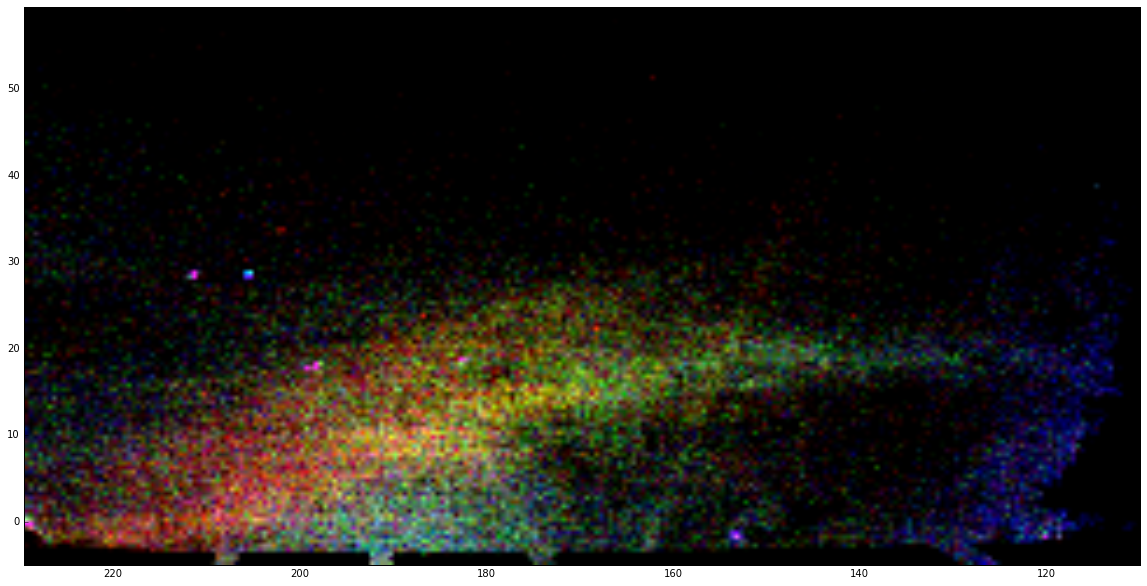

In [109]:
fig, ax = plt.subplots(figsize=(20,10))
img = ax.imshow(rgb.T, origin='lower', extent=(ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]), aspect='auto')
ax.set_xlim(ra_edges[-1],ra_edges[0])
ax.set_ylim(dec_edges[0],dec_edges[-1])
plt.show()